# Batch Processing for Multiple-Choice Questions

# 1. Install Litelines

In [1]:
%pip install --quiet --upgrade litelines

## 2. Download a model and its tokenizer

In [2]:
# Use cuda for faster inference
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
assert device == torch.device("cuda"), "In the Runtime tab, please Change runtime type to GPU"

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device)

## 3. Prepare the inputs to the LLM

In [4]:
user_inputs = ["What is the capital of France?", "What is the capital of Italy?", "What is the capital of Spain?"]
alternatives = """
A) Madrid
B) Paris
C) Rome
"""
messages = [[{"role": "user", "content": user_input + alternatives}] for user_input in user_inputs]
formatted_messages = [
    tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True) for message in messages
]
inputs = tokenizer(
    formatted_messages,
    return_tensors="pt",
    padding=True,
    truncation=True
).to(device)
prompt_length = inputs['input_ids'].shape[-1]

## 4. Define a processor through a regular expression

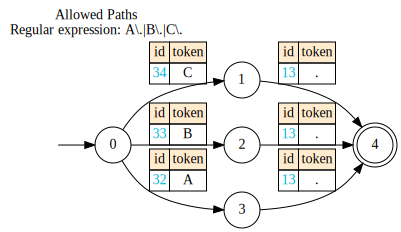

In [5]:
from litelines.transformers import SchemaProcessor

processor = SchemaProcessor(response_format=r"A\.|B\.|C\.", tokenizer=tokenizer)
processor.show_graph()

## 5. Generate a structured response

In [6]:
outputs = model.generate(
    inputs.input_ids,
    attention_mask=inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    logits_processor=[processor],
    temperature=0.1
)
generated_texts = tokenizer.batch_decode([output[prompt_length:] for output in outputs], skip_special_tokens=True)
formatted_strings = [f"Question: {user_inputs[i]+alternatives}\n\x1b[34mResponse:\x1b[0m \x1b[31m{generated_texts[i]}\x1b[0m" for i in range(len(user_inputs))]
for string in formatted_strings:
    print(string)
    print()

Question: What is the capital of France?
A) Madrid
B) Paris
C) Rome

Response: B.

Question: What is the capital of Italy?
A) Madrid
B) Paris
C) Rome

Response: C.

Question: What is the capital of Spain?
A) Madrid
B) Paris
C) Rome

Response: A.



## 6. Visualize the selected paths

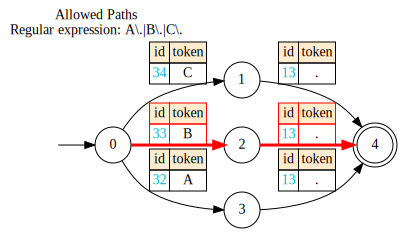

In [7]:
processor.show_graph(batch_number=0)

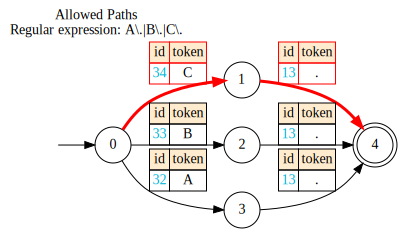

In [8]:
processor.show_graph(batch_number=1)

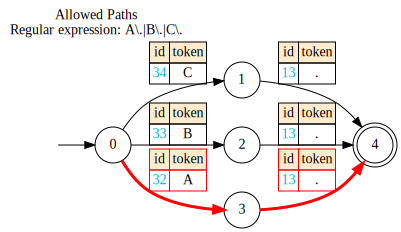

In [9]:
processor.show_graph(batch_number=2)